# HOMEWORK 2 NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---
Student: Matteo Grandin
---
id: 2020374

# Unsupervised Deep Learning

### General overview
 In this homework you will learn how to implement and test neural network models for
solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen
before, the homework will be based on images of FashionMNIST. However, you can optionally explore
different image collections (e.g., Caltech or Cifar) or other datasets based on your interests. The basic tasks
for the homework will require to test and analyze the convolutional autoencoder implemented during the
Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar
performance considering the relatively small size of the FashionMNIST images. As for the previous
homework, you should explore the use of advanced optimizers and regularization methods. Learning
hyperparameters should be tuned using appropriate search procedures, and final accuracy should be
evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and
variational / adversarial architectures.

## Convolutional autoencoder
- implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and
some examples of image reconstruction; explore advanced optimizers and regularization methods

In [1]:
## NOTEBOOK CONTROLS
perform_grid_search = False
load_good_model = False #load model from file, if false retrain

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from sklearn.model_selection import KFold # this module is useful to split data into training and test sets

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import pickle

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu") #for debugging
print(f'Selected device: {device}')

if not os.path.exists('data/training'):
    os.makedirs('data/training')

Selected device: cuda


In [3]:
## Dataset
# training and validation will be performed on the training dataset
train_dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True)
# test dataset will only be used for evaluating final model performance
test_dataset  = torchvision.datasets.FashionMNIST('data', train=False, download=True)

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
num_labels = len(label_names)

In [4]:
## Data transformation
train_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform


In [5]:
## Model definition
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True),
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            #third linear layer
            nn.Linear(in_features=32, out_features=encoded_space_dim)
        )
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        ) 
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x
        

In [6]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, apply_softmax=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for (image_batch, _) in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        if apply_softmax:
            encoded_data = F.softmax(encoded_data, dim=1)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add loss to the list
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    #print(f"Batch Train loss: {train_loss}")
    return train_loss

### Testing function
def validate_epoch(encoder, decoder, device, dataloader, loss_fn, apply_softmax=False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for (image_batch, _) in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            if apply_softmax:
                encoded_data = F.softmax(encoded_data, dim=1)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        #print(f"Batch Validation loss: {val_loss}")
    return val_loss.item()

In [7]:
#useful functions
def plot_losses(train_losses, val_losses, title, save_name=None, label1="Training loss", label2="Validation loss", max_y=0.2):
    fig = plt.figure(figsize=(12,4))
    plt.plot(train_losses, label=label1)
    plt.plot(val_losses, label=label2)
    plt.ylim(0,max_y)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    if save_name is None:
        save_name = title
    fig.savefig("images_L1/"+save_name+".eps",format="eps", dpi=1200, bbox_inches="tight")
    plt.close()

def reset_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer.reset_parameters()

# 10-dimensional encoded space

In [8]:
# function to get model accuracy
def get_accuracy(encoder, dataset, single_layer=None):
    this_dataloader = DataLoader(dataset, batch_size=20000)
    correct = 0
    total = 0
    with torch.no_grad():
        for (data, label) in tqdm(this_dataloader):
            data, label = data.to(device), label.to(device)
            # Compute the output
            output = encoder(data)
            if single_layer is not None:
                output = single_layer(output)
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the total number of correct predictions
            correct += pred.eq(label.view_as(pred)).sum() #.item()
            # Add to the total number of predictions
            total += data.shape[0]
    return correct/total

### Test on examples
def test_on_example(n_example, encoder, decoder, title, save_name=None, test_dataset=test_dataset):
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[n_example][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image')
    plt.tight_layout()
    axs[0].axis('off')
    axs[1].axis('off')
    plt.pause(0.1)
    plt.show()
    if save_name is None:
        save_name = title
    fig.savefig(f"images_L1/{save_name}.png", dpi=1000, bbox_inches='tight')
    plt.close()

#function to find good inputs, where the net is confident
def find_good_inputs(encoder10, test_dataset, device):
    # find an input for each class for which the encoder10 is very confident
    fig, axs = plt.subplots(1, 10, figsize=(15,6))
    inputs = []
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    encoder10.eval()
    for i in range(10):
        found = False
        for (image, label) in test_dataloader:
            if label == i:
                image, label = image.to(device), label.to(device)
                output = encoder10(image)
                output = torch.softmax(output, dim=1)
                pred = output.argmax(dim=1, keepdim=True)
                confidence = output.detach().cpu().numpy()[0][i]
                # check if the prediction is correct
                if pred == label and confidence > 0.95:
                    print(f"{label_names[i]} - confidence: {confidence}")
                    inputs.append(image)
                    # plot image
                    axs[i].imshow(image.squeeze().detach().cpu().numpy(), cmap='gray')
                    found = True
                    break
        if not found:
            print(f"{label_names[i]} not found")
    plt.show()
    return inputs

def find_inputs(test_dataset):
    inputs = []
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    for i in range(10):
        found = False
        for (image, label) in test_dataloader:
            if label == i:
                inputs.append(image)
                found = True
                break
        if not found:
            print(f"{label_names[i]} not found")
    return inputs
                

#train function
def train(enc, dec, epochs, train_dataset, test_dataset, loss_fn, optim, device, apply_softmax=False):
    # Define the dataloader
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    # Define the lists to store the losses
    train_losses = []
    test_losses = []
    enc, dec = enc.to(device), dec.to(device)
    enc.train()
    dec.train()
    # Train the model
    for epoch in tqdm(range(epochs)):
        # Train the model
        train_loss = train_epoch(enc, dec, device, train_loader, loss_fn, optim, apply_softmax=apply_softmax)
        # Validate the model
        test_loss = validate_epoch(enc, dec, device, test_loader, loss_fn, apply_softmax=apply_softmax)
        # Add the loss to the list
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return enc, dec, train_losses, test_losses

In [9]:
#parameters
num_epochs10 = 50 #100 ~ 20 min
encoded_space_dim = 10
encoder10, decoder10 = Encoder(encoded_space_dim), Decoder(encoded_space_dim)
optim10 = torch.optim.Adam(list(encoder10.parameters()) + list(decoder10.parameters()), lr=1e-3, weight_decay=0.0)
#nn.L1Loss()
loss_fn10 = nn.L1Loss()
train_losses = []
val_losses = []

100%|██████████| 50/50 [09:40<00:00, 11.62s/it]


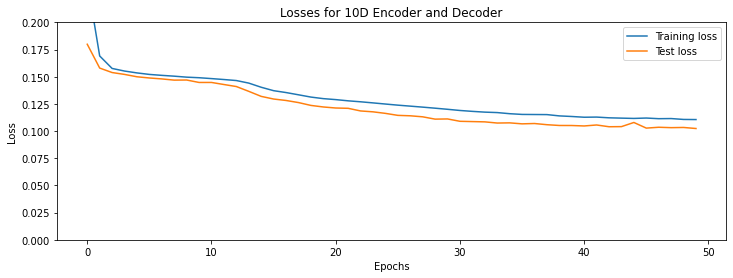

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
# execute the training loop

if not load_good_model: #train from scratch
    encoder10, decoder10, train_losses, test_losses = train(encoder10, decoder10, num_epochs10, train_dataset, test_dataset, loss_fn10, optim10, device, apply_softmax=False)
    # save model
    torch.save(encoder10.state_dict(), f"good_models_L1/encoder10_final_{num_epochs10}.pt")
    torch.save(decoder10.state_dict(), f"good_models_L1/decoder10_final_{num_epochs10}.pt")
    # save losses
    with open(f"good_models_L1/losses10_{num_epochs10}.pkl", 'wb') as f:
        pickle.dump([train_losses, test_losses], f)
else: #load pretrained model
    encoder10.load_state_dict(torch.load(f"good_models_L1/encoder10_final_{num_epochs10}.pt"))
    decoder10.load_state_dict(torch.load(f"good_models_L1/decoder10_final_{num_epochs10}.pt"))
    print("Loaded pretrained model")
    #load losses
    with open(f"good_models_L1/losses10_{num_epochs10}.pkl", 'rb') as f:
        train_losses, test_losses = pickle.load(f)

#plot losses
plot_losses(train_losses, test_losses, title="Losses for 10D Encoder and Decoder", save_name=f"losses10_{num_epochs10}", label2="Test loss")

In [11]:
### Test the model
# calculate loss on training set
encoder10, decoder10 = encoder10.to(device), decoder10.to(device)
train_loss = validate_epoch(encoder10, decoder10, device, DataLoader(train_dataset, batch_size=60000), nn.L1Loss())
print(f"Train loss: {train_loss}")
# calculate loss on test set
test_loss = validate_epoch(encoder10, decoder10, device, DataLoader(test_dataset, batch_size=20000), nn.L1Loss())
print(f"Test loss: {test_loss}")

Train loss: 0.10225579142570496
Test loss: 0.10236018896102905


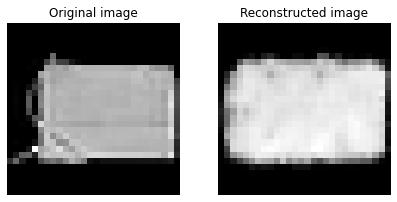

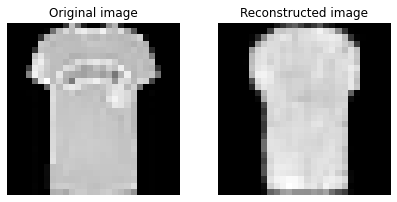

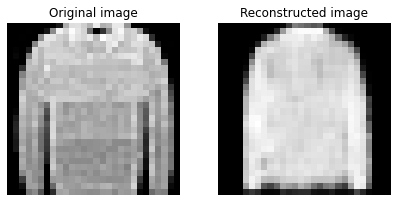

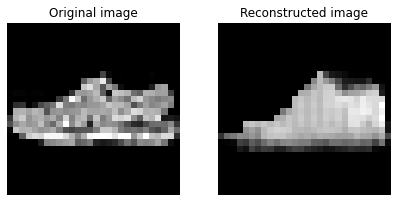

In [12]:
for i in range(18,22):
    test_on_example(i, encoder10, decoder10, title="Test on example 10D-ESD", save_name=f"10D_reconstruction_example_{i}")

## 10-D Supervised fine tuning and comparison with supervised methods
- 1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task, and compare
classification accuracy and learning speed with results achieved in Homework 1

### Encoder outputs for different classes before tuning

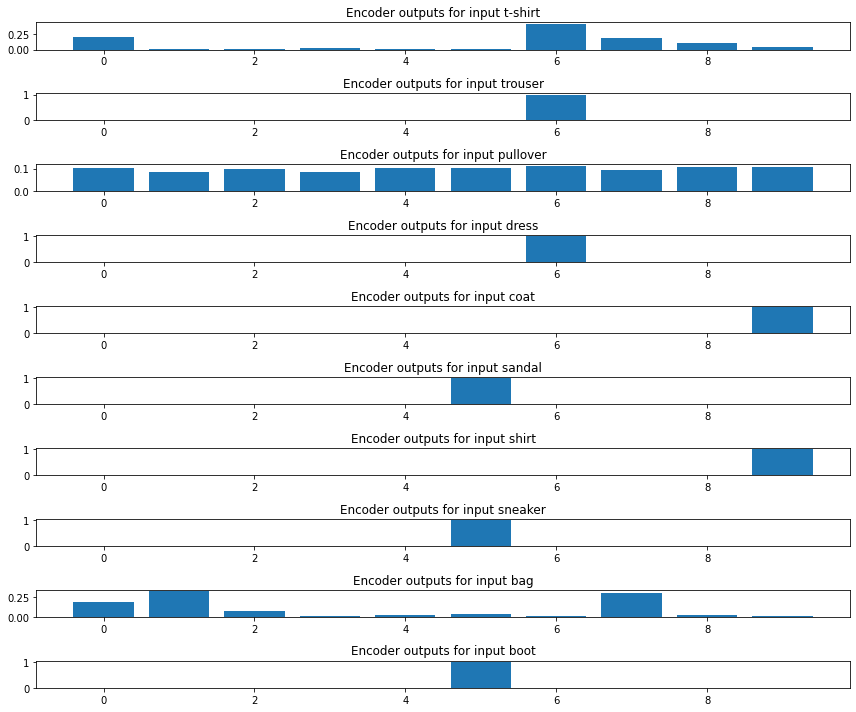

In [13]:
# inputs = find_good_inputs(encoder10, test_dataset, device)
inputs = find_inputs(test_dataset)
encoder10 = encoder10.to(device)
encoder10.eval()
outputs = []
with torch.no_grad():
    for i in inputs:
        i = i.to(device)
        out = encoder10(i)
        out = F.softmax(out, dim=1)
        outputs.append(out.cpu().numpy())

#plot outputs
fig1, axs = plt.subplots(10, 1, figsize=(12, 10))
for i in range(10):
    out = outputs[i][0]
    # plot historgrams 
    axs[i].bar(range(10), out)
    axs[i].set_title(f"Encoder outputs for input {label_names[i]}")
plt.tight_layout()
plt.show()
#save fig
fig1.savefig(f"images_L1/encoder10_outputs_not_tuned_{num_epochs10}.png")

## Finetuning

To fine tune the encoder10, the idea is to create a set of weights from the hidden representation to the output target encoded as a 10-vector (one-hot encoding vector of the class, like class 3 => [0001000000])). The idea for training is divided in steps:
- step 1: fix the encoder2/encoder10 weights and train only the new layer
- step 2: for a specified number of epochs repeat:
    - fix encoder10 and train encoder10 using nn.CrossEntropyLoss() wrt the target
    - fix encoder10 and train encoder10 using nn.L1Loss() wrt to the initial image

In [14]:
## step 1: single layer NN training
# create the single layer NN to match the encoded_space_dim to the 10-dim one-encoded vector
class SingleLayerNN(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc = nn.Linear(encoded_space_dim, 10)
    def forward(self, x):
        return self.fc(x)

slm10 = SingleLayerNN(encoded_space_dim) #slm10 = single layer matcher

# step 1: single layer NN training
torch.manual_seed(0)
#params
single_layer_num_epochs = 5
# dataloader
slm_train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#loss
sl_loss_fn = nn.CrossEntropyLoss()
#optimizer
sl_optimizer = torch.optim.Adam(slm10.parameters(), lr=1e-3)
# to gpu
slm10.to(device)

if not load_good_model:
    #train loop
    for epoch in tqdm(range(single_layer_num_epochs)):
        #print(f"Epoch {epoch+1}/{single_layer_num_epochs}")
        slm10.train()
        epoch_loss = []
        for (data, label) in slm_train_dataloader:
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # use pretrained encoder2 to encode the data
            encoded_data = encoder10(data)
            # Zero the gradients
            sl_optimizer.zero_grad()
            # Compute the output
            output = slm10(encoded_data)
            assert output.shape == target.shape
            # Compute the loss
            loss = sl_loss_fn(output, target)
            # Compute the gradients
            loss.backward()
            # Update the weights
            sl_optimizer.step()
            #batch loss
            loss_batch = loss.item()
            epoch_loss.append(loss_batch)
        # Return the average training loss
        epoch_loss = np.mean(epoch_loss)
        #print(f"epoch loss: {epoch_loss}")

    step_1_train_accuracy = get_accuracy(encoder10, train_dataset, single_layer=slm10)
    step_1_test_accuracy = get_accuracy(encoder10, test_dataset, single_layer=slm10)
    #print train and test accuracy with 3 decimal places
    print(f"Train Accuracy WITHOUT Decoder tuning: {round(step_1_train_accuracy.item()*100, 1)} %")
    print(f"Test Accuracy WITHOUT Decoder tuning: {round(step_1_test_accuracy.item()*100, 1)} %")

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Train Accuracy WITHOUT Decoder tuning: 43.1 %
Test Accuracy WITHOUT Decoder tuning: 43.1 %


In [15]:
## STEP 2: Fine tuning
torch.manual_seed(42)
# this value decides how much the training will focus on correctly predicting labels vs reconstruncting the inputs
mse_multiplier = 5 #8 
step2_num_epochs = 50 #120 ~ 25 min
target_losses, reconstruction_losses = [], []

#load model
if load_good_model:
    decoder10.load_state_dict(torch.load(f'good_models_L1/decoder10_finetuned_{step2_num_epochs}.pt'))
    encoder10.load_state_dict(torch.load(f'good_models_L1/encoder10_finetuned_{step2_num_epochs}.pt'))
    slm10.load_state_dict(torch.load(f'good_models_L1/slm10_finetuned_{step2_num_epochs}.pt'))
    print("Loaded pretrained models")
    #load losses
    with open(f"good_models_L1/losses10_finetuned_{step2_num_epochs}.pkl", 'rb') as f:
        target_losses, reconstruction_losses = pickle.load(f)
else:
    # dataloader
    train_dataloader_2 = DataLoader(train_dataset, batch_size=256, shuffle=True)
    #loss
    loss_fn_2 = nn.CrossEntropyLoss()
    dec_loss_fn = nn.L1Loss()
    #optimizer
    params_to_optimize = [
                {'params': encoder10.parameters()},
                {'params': decoder10.parameters()},
                {'params': slm10.parameters()}
            ]
    optimizer_2 = torch.optim.Adam(params_to_optimize, lr=1e-3, weight_decay=1e-5)
    # to gpu
    encoder10.to(device)
    decoder10.to(device)

    #train loop
    target_losses = []
    reconstruction_losses = []
    for epoch in tqdm(range(step2_num_epochs)):
        #print(f"Epoch {epoch+1}/{step2_num_epochs}")
        encoder10.train()
        decoder10.train()
        epoch_losses2 = []
        dec_losses = []
        for (data, label) in train_dataloader_2:
            # Zero the gradients
            optimizer_2.zero_grad()
            ## ENCODER TRAINING + SINGLE LAYER MATCHER TRAINING
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # use pretrained encoder to encode the data
            encoded_data = encoder10(data)
            # Compute the output
            slm_out = slm10(encoded_data)
            assert slm_out.shape == target.shape
            # Compute the loss
            loss2 = loss_fn_2(slm_out, target) #cross entropy loss
            # Compute the gradients
            loss2.backward(retain_graph=True)
            ## DECODER TRAINING
            # Compute the output
            decoded_data = decoder10(encoded_data)
            # Compute the loss
            dec_loss = mse_multiplier*dec_loss_fn(decoded_data, data) # for more weightage
            # Compute the gradients
            dec_loss.backward()

            # Update the weights
            optimizer_2.step()

            #batch loss
            loss_batch2 = loss2.item()
            epoch_losses2.append(loss_batch2)
            dec_loss_batch = dec_loss.item()
            dec_losses.append(dec_loss_batch)

        # Return the average training loss
        epoch_loss2 = np.mean(epoch_losses2)
        #print(f"target loss: {epoch_loss2}")
        target_losses.append(epoch_loss2)
        dec_loss = np.mean(dec_losses)
        #print(f"reconstruction loss (x{mse_multiplier}): {dec_loss}")
        reconstruction_losses.append(dec_loss)
    
    torch.save(decoder10.state_dict(), f'good_models_L1/decoder10_finetuned_{step2_num_epochs}.pt')
    torch.save(encoder10.state_dict(), f'good_models_L1/encoder10_finetuned_{step2_num_epochs}.pt')
    torch.save(slm10.state_dict(), f'good_models_L1/slm10_finetuned_{step2_num_epochs}.pt')
    #save losses
    with open(f"good_models_L1/losses10_finetuned_{step2_num_epochs}.pkl", 'wb') as f:
        pickle.dump((target_losses, reconstruction_losses), f)

100%|██████████| 50/50 [10:03<00:00, 12.07s/it]


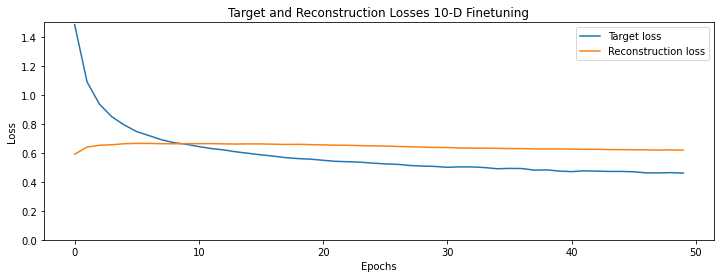

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

Train Accuracy After Decoder Tuning: 84.3 %
Test Accuracy After Decoder Tuning: 82.7 %


In [16]:
#plot losses
plot_losses(target_losses, reconstruction_losses, 
                title="Target and Reconstruction Losses 10-D Finetuning", save_name=f"losses_encoder10_finetuned_{step2_num_epochs}",
                label1="Target loss",label2="Reconstruction loss",max_y=1.5)
#accuracy
step_2_train_accuracy = get_accuracy(encoder10, train_dataset, single_layer=slm10)
step_2_test_accuracy = get_accuracy(encoder10, test_dataset, single_layer=slm10)
#print train and test accuracy with 3 decimal places
print(f"Train Accuracy After Decoder Tuning: {round(step_2_train_accuracy.item()*100, 1)} %")
print(f"Test Accuracy After Decoder Tuning: {round(step_2_test_accuracy.item()*100, 1)} %")

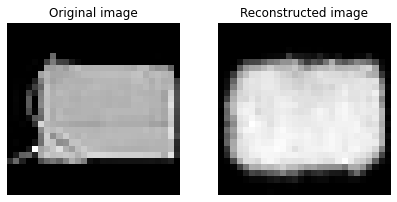

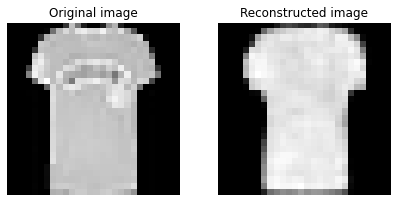

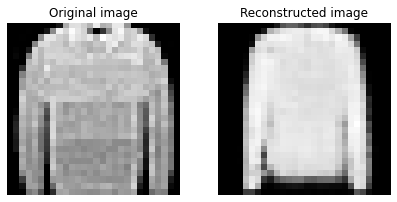

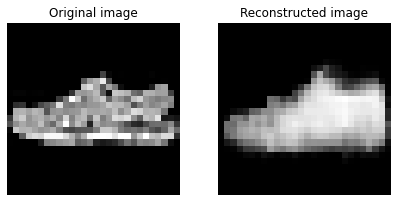

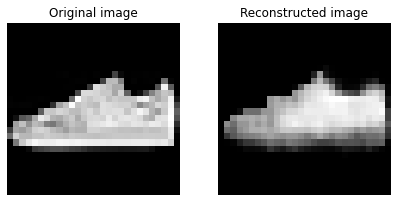

In [17]:
#test on examples
for i in range(18,23):
    test_on_example(i, encoder10, decoder10, title="Test after supervised fine tuning", save_name=f"10D_reconstruction_example_finetuned_{i}")

## 10-D Latent space exploration and generation of new samples
- 2 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes

### Encoder outputs for different classes

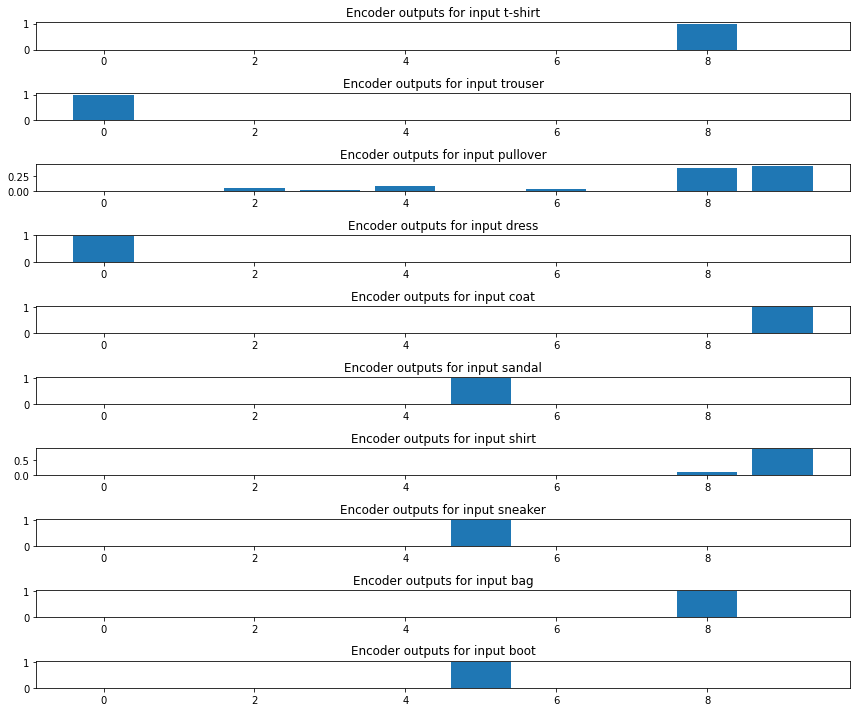

In [18]:
# inputs = find_good_inputs(encoder10, test_dataset, device)
inputs = find_inputs(test_dataset)
encoder10 = encoder10.to(device)
encoder10.eval()
outputs = []
with torch.no_grad():
    for i in inputs:
        i = i.to(device)
        out = encoder10(i)
        out = torch.softmax(out, dim=1)
        outputs.append(out.cpu().numpy())

#plot outputs
fig2, axs = plt.subplots(10, 1, figsize=(12, 10))
for i in range(10):
    out = outputs[i][0]
    # plot historgrams 
    axs[i].bar(range(10), out)
    axs[i].set_title(f"Encoder outputs for input {label_names[i]}")
plt.tight_layout()
plt.show()
#save fig
fig2.savefig(f"images_L1/encoder10_outputs_finetuned_{step2_num_epochs}.png")





Some bold statements from the encoder here, apparently a boot is a sneaker, hard to blame though.

### PCA

In [19]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder10.eval()
    with torch.no_grad():
        encoded_img  = encoder10(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
import plotly.express as px
fig2a = px.scatter(encoded_samples_reduced_PCA, x=0, y =1, 
    color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
fig2a.show()
#save figure as eps
fig2a.write_image(f'images_L1/10D_finetuned_PCA.eps', width=2000, height=700)

# very interesting but computationally expensive
# pca3 = PCA(n_components=3)
# encoded_samples_reduced_PCA3 = pca3.fit_transform(encoded_samples)
# fig2b = px.scatter_3d(encoded_samples_reduced_PCA3, x=0, y=1, z=2, 
#     color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
# fig2b.show()


100%|██████████| 10000/10000 [00:08<00:00, 1166.84it/s]


### t-SNE

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
fig3a = px.scatter(encoded_samples_reduced_TSNE, x=0, y =1, 
    color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
fig3a.show()
fig3a.write_image(f'images_L1/10D_finetuned_TSNE.eps', width=2000, height=700)

# very interesting but computationally expensive
# tsne3 = TSNE(n_components=3)
# encoded_samples_reduced_TSNE3 = tsne3.fit_transform(encoded_samples)
# fig3b = px.scatter_3d(encoded_samples_reduced_TSNE3, x=0, y=1, z=2,
#     color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
# fig3b.show()

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### New samples generation
To generate new samples the idea is to take all the examples for which the classification is confident and correct, then calculate the encodint for these examples and find the mean and std of the encodings for each class, to have an approxximation of the average good encoding. To generate samples we start from the avg and we inject noise using the std.

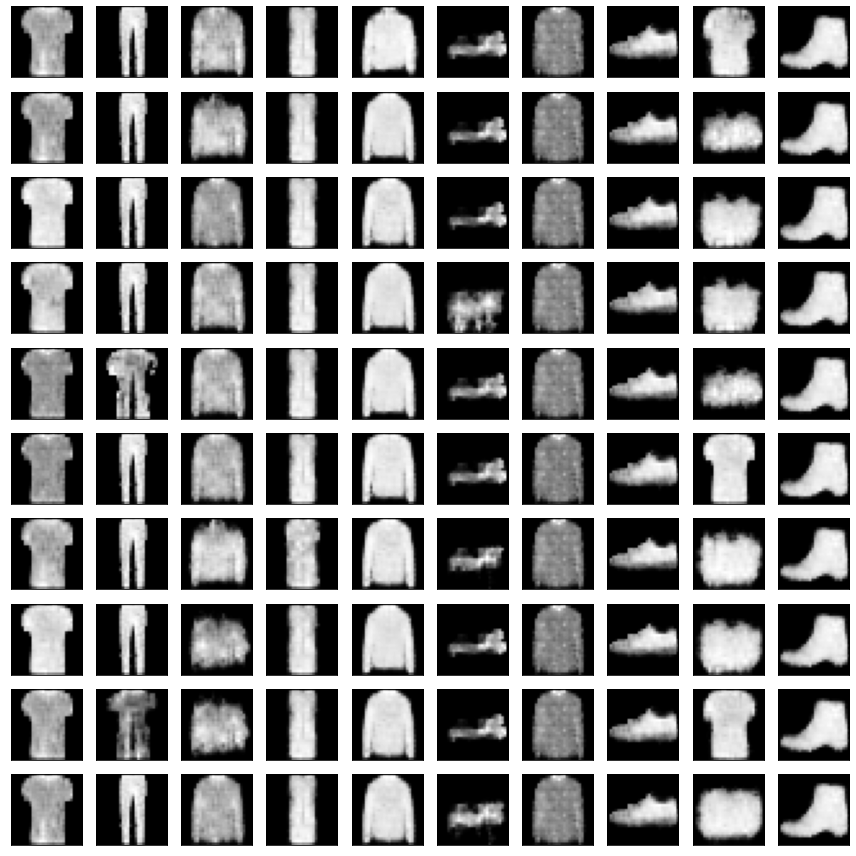

In [24]:
torch.manual_seed(42)
good_encodings = [[] for _ in range(10)]
with torch.no_grad():
    encoder10.eval()
    for imgs, labels in DataLoader(test_dataset, batch_size=len(test_dataset)):
        imgs = imgs.to(device)
        encoded_imgs = encoder10(imgs)
        class_outs = torch.softmax(slm10(encoded_imgs), dim=1)
        class_outs = class_outs.cpu().numpy()
        encoded_images = encoded_imgs.cpu().numpy()
        out_labels = np.argmax(class_outs, axis=1)
        for (out_label, label, class_out, enc_img) in zip(out_labels, labels, class_outs, encoded_images):
            if out_label == label and class_out[label] > 0.8: #correct and confident prediction
                good_encodings[label].append(enc_img)
#find the average encoding for each class
avg_encoding = []
std_encoding = []
for i in range(10):
    if len(good_encodings[i]) > 0:
        #average the encodings
        avg_encoding.append(np.mean(good_encodings[i], axis=0))
        #get standard deviation
        std_encoding.append(np.std(good_encodings[i], axis=0))
    else:
        print(f"No good encodings for class {i}")
        avg_encoding.append(np.zeros(encoded_imgs.shape[1]))
        std_encoding.append(np.zeros(encoded_imgs.shape[1]))

fig, axs = plt.subplots(10, 10, figsize=(12, 12))
with torch.no_grad():
    decoder10.eval()
    for i in range(10):
        for j in range(10):
            encoded_img = torch.from_numpy(avg_encoding[i]).to(device)
            std = torch.from_numpy(std_encoding[i]).to(device)
            #add random noise to the encoding
            encoded_img = encoded_img + 0.5 * torch.normal(mean=torch.zeros(encoded_img.shape, device=device), std=std)
            generated_img = decoder10(encoded_img.unsqueeze(0)).squeeze(0).squeeze(0).cpu().numpy()
            # generated_img = np.transpose(generated_img, (1, 2, 0))
            axs[j][i].imshow(generated_img, cmap='gray')
            axs[j][i].set_xticks([])
            axs[j][i].set_yticks([])

    
#show fig
plt.tight_layout()
plt.show()
#save fig
fig.savefig(f"images_L1/new_samples_generated_finetuned_10_{step2_num_epochs}.png", dpi=500)